In [1]:
import gc
import glob
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import randrange
from tqdm import tqdm, tnrange
from tqdm.notebook import tqdm_notebook

import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from keras.optimizer_v2.gradient_descent import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Lambda, Dropout, LeakyReLU, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from mlxtend.evaluate import accuracy

from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam
#from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.applications import VGG16

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

In [3]:
path_data = "data/data_palm_vein/NIR"

In [4]:
def load_img(path, xdim=128, ydim=128, nb_of_users = 500):
    label_names = []
    X = []
    y = []
    nb_of_users = nb_of_users - 1
    count = 0
    identity = -1
    directories = os.listdir(path)
    directories.sort()
    for dirname in tqdm_notebook(directories, desc="Loading images..."):
        if dirname == ".DS_Store": continue
        label_names.append(dirname)
        data_path = os.path.join(path + "/" + dirname, '*g')
        files = glob.glob(data_path)
        if identity >= nb_of_users: break
        identity += 1
        files.sort()
        for f1 in files:
            img = cv2.imread(f1, cv2.IMREAD_GRAYSCALE)
            #img = cv2.imread(f1)
            #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            img = cv2.resize(img,(int(xdim*1), int(ydim*1)))
            #X.append([np.array(img), np.array(img), np.array(img)])
            #X.append(np.array(img))
            #X.append(np.array(img))
            X.append(np.array(img))
            #stacked_img = np.stack((img,)*3, axis=-1)
            #X.append(stacked_img)
            y.append(identity)
            count += 1
    X = np.array(X)
    y = np.array(y)
    print("\n ================= Summary of extraction ================= \n")
    print(count, ' images lues')
    print("\nX.shape = ", X.shape)
    print("y.shape = ", y.shape)
    gc.collect()
    return X, y, label_names

In [5]:
X, y, label_names = load_img(path_data, nb_of_users=50, xdim=128, ydim=128)

Loading images...:   0%|          | 0/501 [00:00<?, ?it/s]


 ================= Summary of extraction ================= 

600  images lues

X.shape =  (600, 128, 128)
y.shape =  (600,)


In [6]:
X = X / 255.
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = to_categorical(y)

print("\nPREPROCESSING DATA")
print("-----------------------------------------")
print("\nX shape : {}".format(X.shape))
print("-----------------------------------------")
print("y shape : {}\n".format(y.shape))
print("\n\n-----------------------------------------")
print("Il y a {} utilisateur(s) dans le dataset prélevé.".format(y.shape[1]))


PREPROCESSING DATA
-----------------------------------------

X shape : (600, 128, 128, 1)
-----------------------------------------
y shape : (600, 50)



-----------------------------------------
Il y a 50 utilisateur(s) dans le dataset prélevé.


In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nSplitting data ...\n")
print("\n=============================== Splitting data =============================== \n")
print("\nX_train shape : {}    |   y_train shape : {}".format(X_train.shape, y_train.shape))
print("------------------------------------------------------------------------------")
print("(X_temp shape : {}    |   y_temp shape  : {})\n".format(X_temp.shape, y_temp.shape))


Splitting data ...


=============================== Splitting data =============================== 


X_train shape : (480, 128, 128, 1)    |   y_train shape : (480, 50)
------------------------------------------------------------------------------
(X_temp shape : (120, 128, 128, 1)    |   y_temp shape  : (120, 50))



In [8]:
def zfnet_model(input_shape=(128, 128, 3), nombre_classes=500):
    model = Sequential()
    model.add(Conv2D(filters=256, kernel_size=(2, 2), padding="same", activation="LeakyReLU",input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(units=nombre_classes, activation="softmax"))

    print(model.summary())
    print("\n ================= model ================= \n")


    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00000000001)
#    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
#                                            factor=0.1, patience=1, min_lr=0.00001)


    return model, learning_rate_reduction

In [9]:
Nombre_classes = y.shape[1]
input_shape = (X.shape[1], X.shape[2], 1)
print("\nNombres de classes : {}   |   Input shape : {}\n".format(Nombre_classes, input_shape))


Nombres de classes : 50   |   Input shape : (128, 128, 1)



In [10]:
model, learning_rate_reduction = zfnet_model(input_shape=input_shape, nombre_classes=Nombre_classes)

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 256)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 1048576)           0         
_________________________________________________________________
dense (Dense)                (None, 50)                52428850  
Total params: 52,430,130
Trainable params: 52,430,130
Non-trainable params: 0
_________________________________________________________________
None

 ================= ZFNET model ================= 



In [14]:
epochs = 20
batch_size = 32
print("\n ================= Training : ZFNET model ================= \n")
print("  Epochs :  {}   |   Batch size : {} ".format(epochs, batch_size))
print("\n ========================================================== \n")

trained_model = model.fit(X_train, y_train, validation_data=(X_temp, y_temp), epochs=epochs, callbacks=learning_rate_reduction)


 ================= Training : ZFNET model ================= 

  Epochs :  20   |   Batch size : 32 


Epoch 1/20
15/15 [==============================] - 33s 2s/step - loss: 2.1777 - accuracy: 0.7750 - val_loss: 2.2518 - val_accuracy: 0.8917
Epoch 2/20
15/15 [==============================] - 33s 2s/step - loss: 1.9768 - accuracy: 0.8313 - val_loss: 2.4167 - val_accuracy: 0.6250
Epoch 3/20
15/15 [==============================] - 33s 2s/step - loss: 1.8064 - accuracy: 0.9021 - val_loss: 2.0620 - val_accuracy: 0.8417

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.
Epoch 4/20
15/15 [==============================] - 33s 2s/step - loss: 1.6658 - accuracy: 0.9313 - val_loss: 1.9300 - val_accuracy: 0.9250
Epoch 5/20
15/15 [==============================] - 33s 2s/step - loss: 1.5431 - accuracy: 0.9521 - val_loss: 1.8506 - val_accuracy: 0.9167
Epoch 6/20
15/15 [==============================] - 33s 2s/step - loss: 1.4400 - accuracy: 0.9667 - val_loss: 1.694

In [15]:
val = model.evaluate(X_temp, y_temp)

print("\n ================= Evaluation : ZFNET model ================= \n")
print("  With : \n")
print("Batch size         :  {}     |   Epochs      : {} ".format(batch_size, epochs))
print("Nombres de classes :  {}     |   Input shape : {} \n".format(Nombre_classes, input_shape))
print("\n ============================================================= \n")

print("  Results : \n")
print("Loss  : %.2f%%" % (val[0] * 100))
print("Score : %.2f%%" % (val[1] * 100))

4/4 [==============================] - 6s 1s/step - loss: 1.0162 - accuracy: 0.9917

 ================= Evaluation : ZFNET model ================= 

  With : 

Batch size         :  32     |   Epochs      : 20 
Nombres de classes :  50     |   Input shape : (128, 128, 1) 



  Results : 

Loss  : 101.62%
Score : 99.17%


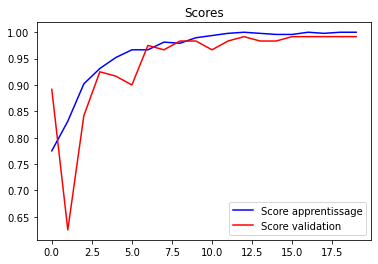

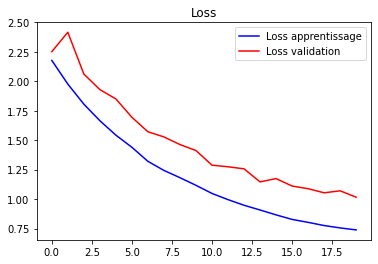

In [16]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
def plot_loss(train):
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Loss apprentissage')
    plt.plot(epochs, val_loss, 'r', label='Loss validation')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
plot_scores(trained_model)
plot_loss(trained_model)

In [17]:
!mkdir -p saved_model
model.save('saved_model/model_1layerCONVPOOL._40epochs.h5')